## 【問題1】公式チュートリアルモデルを分担して実行

TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。


[models/tutorials at master · tensorflow/models](https://www.tensorflow.org/tutorials/)


選択　Image classification

選択理由  Kaggle の Dogs vs Cats データセットをフィルタリングとあるので Dogs vs Catsを少しやったことがあるので選択した

1. データの調査及び理解
2. 入力パイプラインの構築
3. モデルの構築
4. モデルの学習
5. モデルのテスト
6. モデルの改善とプロセスの繰り返し

## パッケージのインポート

まずは必要なパッケージをインポートすることから始めましょう。 osパッケージはファイルとディレクトリ構造を読み込み、 NumPy は python リストの numpy 配列への変換と必要な行列演算の実行、 matplotlib.pyplot はグラフの描画や学習データおよび検証データに含まれる画像の表示、に利用します。

モデルの構築に必要な TensorFlow と Keras クラスをインポートします。

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## データの読み込み

データセットのダウンロードから始めます。このチュートリアルでは、 Kaggle の Dogs vs Cats データセットをフィルタリングしたバージョンを使用します。データセットのアーカイブバージョンをダウンロードし、"/tmp/"ディレクトリに保存します。

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 2s 0us/step


データセットのディレクトリ構造は次のとおりです

    cats_and_dogs_filtered
    |__ train
        |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
        |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
    |__ validation
        |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
        |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]

データの内容を抽出した後、学習および検証セットのための適切なファイルパスで変数を設定します。

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

学習用犬、猫画像と検証用犬、猫画像に分ける

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')  # 学習用の猫画像のディレクトリ
train_dogs_dir = os.path.join(train_dir, 'dogs')  # 学習用の犬画像のディレクトリ
validation_cats_dir = os.path.join(validation_dir, 'cats')  # 検証用の猫画像のディレクトリ
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # 検証用の犬画像のディレクト

## データの理解

学習および検証ディレクトリの中にある猫と犬の画像の数を見てみましょう

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [ ]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


ネットワークの学習中に使用する変数を設定します

In [ ]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## データの準備
モデルにデータを送る前に、画像を適切に前処理された浮動小数点テンソルにフォーマットします。

1.ディスクから画像を読み取ります。 

2.これらの画像のコンテンツをデコードし、RGB値にしたがって適切なグリッド形式に変換します。 

3.それらを浮動小数点テンソルに変換します。 

4.ニューラルネットワークは小さな入力値を扱う方が適しているため、テンソルを0〜255の値から0〜1の値にリスケーリングします。

幸い、これらすべてのタスクは、 tf.keras によって提供される ImageDataGenerator クラスで実行できます。この ImageDataGenerator はディスクから画像を読み取り、適切なテンソルに前処理を行います。さらに、これらの画像をテンソルのバッチに変換するジェネレータをセットアップします。これは、ネットワーク学習時に便利です。

In [ ]:
#　学習画像、検証画像
train_image_generator = ImageDataGenerator(rescale=1./255) # 学習データのジェネレータ
validation_image_generator = ImageDataGenerator(rescale=1./255) # 検証データのジェネレータ

学習および検証画像のジェネレータを定義したのち、 *flow_from_directory メソッドはディスクから画像をロードし、リスケーリングを適用し、画像を必要な大きさにリサイズ*します。

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


## 学習用画像の可視化

学習用のジェネレータから画像バッチを抽出して可視化します。（この例では32個の画像を抽出し、そのうち5つを matplotlib で描画します。）

In [ ]:
sample_training_images, _ = next(train_data_gen)

next 関数はデータセットからバッチを返します。 next 関数の返り値は （x_train、y_train） の形式で、 x_train は学習用の特徴量、 y_train はそのラベルです。ラベルを破棄して、学習用画像の可視化のみを行います。

In [ ]:
# この関数は、1行5列のグリッド形式で画像をプロットし、画像は各列に配置されます。
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

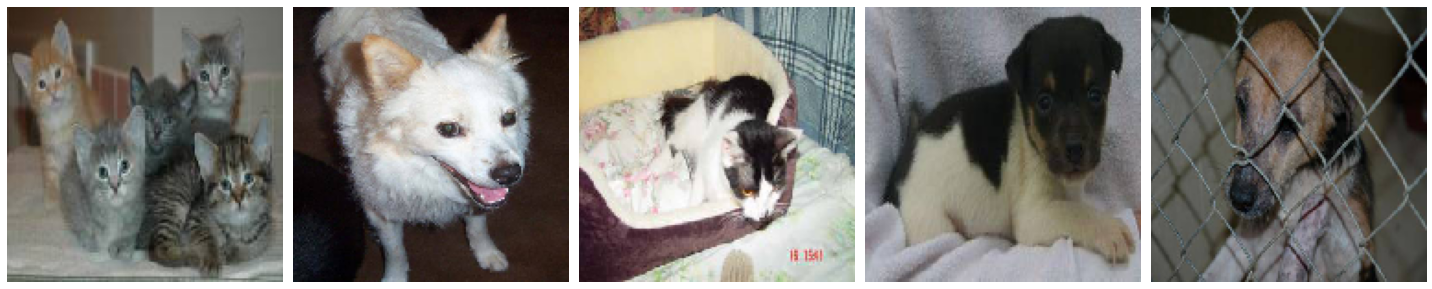

In [ ]:
plotImages(sample_training_images[:5])

## モデルの構築

モデルはmax pooling層を伴う3つの畳み込みブロックからなります。さらに relu 活性化関数によるアクティベーションを伴う512ユニットの全結合層があります。モデルは、シグモイド活性化関数による2値分類に基づいてクラスに属する確率を出力します

In [ ]:
model = Sequential([
    # 16枚、3x3                
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    # 全結合 出力512
    Dense(512, activation='relu'),
    # 全結合　出力10 シグモイド
    Dense(1, activation='sigmoid')
])

padding='valid' : 出力画像は入力画像よりもサイズが小さくなる



![](https://cdn-ak.f.st-hatena.com/images/fotolife/n/ni4muraano/20170129/20170129144610.jpg)

padding='same' : ゼロパディングすることで、出力画像は入力画像と同じサイズになる。

ゼロパディングのメリット 

・端のデータに対する畳み込み回数が増えるので端の特徴も考慮されるようになる

・畳み込み演算の回数が増えるのでパラメーターの更新が多く実行される

・カーネルのサイズや、層の数を調整できる



![](https://cdn-ak.f.st-hatena.com/images/fotolife/n/ni4muraano/20170129/20170129145937.jpg)


input_shape : モデルはどのような入力のshapeを想定しているのかを知る必要があります． このため， Sequential モデルの最初のレイヤーに入力のshapeについての情報を与える必要があります

## モデルのコンパイル
このチュートリアルでは、 ADAM オプティマイザーと binary cross entropy 損失関数を選択します。各学習エポックの学習と検証の精度を表示するために、metrics 引数を渡します。

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

##モデルの概要

すべてのネットワークのレイヤーを見るには、モデルの summary メソッドを利用します

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

## モデルの学習
ImageDataGenerator クラスの fit_generator メソッドを使用して、ネットワークを学習します。

In [ ]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 9s 606ms/step - loss: 0.9032 - accuracy: 0.4893 - val_loss: 0.6895 - val_accuracy: 0.5279
Epoch 2/15
15/15 [==============================] - 9s 570ms/step - loss: 0.6862 - accuracy: 0.5315 - val_loss: 0.6849 - val_accuracy: 0.5692
Epoch 3/15
15/15 [==============================] - 9s 573ms/step - loss: 0.6660 - accuracy: 0.5881 - val_loss: 0.6830 - val_accuracy: 0.5346
Epoch 4/15
15/15 [==============================] - 9s 569ms/step - loss: 0.6303 - accuracy: 0.6512 - val_loss: 0.6429 - val_accuracy: 0.6451
Epoch 5/15
15/15 [==============================] - 9s 571ms/step - loss: 0.6106 - accuracy: 0.6587 - val_loss: 0.6417 - val_accuracy: 0.6618
Epoch 6/15
15/15 [==============================] - 9s 599ms/step - loss: 0.5964 - accuracy: 0.6891 - val_loss: 0.6485 - val_accuracy: 0.6406
Epoch 7/15
15/15 [==============================] - 9s 583ms/step - loss: 0.5456 - accuracy: 0.7329 - val_loss: 0.6037 - val_accuracy: 0.6596
Epoch 

## 学習結果の可視化
ネットワークを学習した後、結果を可視化します。

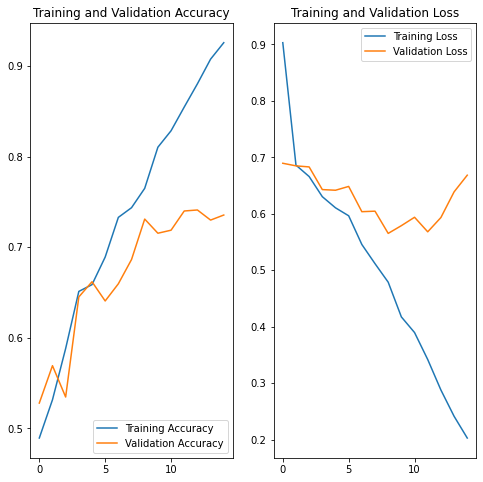

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

プロットからわかるように、学習セットの精度と検証セットの精度は大幅に外れており、モデルは検証セットで約70％の精度しか達成していません。

何がうまくいかなかったかを見て、モデル全体のパフォーマンスを向上してみましょう。

## 過学習
上記のプロットでは、学習セットの精度は時間とともに直線的に向上していますが、検証セットの精度は学習プロセスの中で約70％あたりで頭打ちになっています。そして、学習と検証の精度の違いが顕著です。これは 過学習 のサインです。

学習サンプルが少ない場合、モデルは学習サンプルに含まれるノイズや不要な詳細から学習してしまい、これによって新しいサンプルに対するモデルの性能に悪影響を与えることがあります。この現象は、過学習として知られています。過学習とは、モデルが新しいデータセットに対して汎化するのが難しい状態をいいます。

学習プロセスにおいて過学習に対抗する手段はいくつかあります。このチュートリアルでは、*データ拡張（data Augmentation）* を使用し、さらにモデルに *ドロップアウト（dropout）* を追加します。

## データ拡張（Data augmentation）
過学習は一般に、学習サンプルが少ない場合に発生します。この問題を解決する方法の1つは、十分な数の学習サンプルが含まれるようにデータセットを拡張することです。データ拡張は、既存の学習サンプルに対してランダムな変換を行い、データセットとして利用できそうな画像を生成するアプローチをとります。このデータ拡張の目的は、学習中にモデルがまったくおなじ画像を2回利用しないようにすることです。これによってモデルをデータのより多くの特徴を利用し、より汎化することができます。

tf.keras においては、このデータ拡張を ImageDataGenerator クラスを使用して実装します。データセットに対するさまざまな変換を指定することによって、学習プロセス中にそれが適用されます。

## データの拡張と可視化
最初に、ランダムな水平反転による拡張をデータセットに適用し、それぞれの画像が変換後にどのように見えるかを確認します。

水平反転の適用
このデータ拡張を適用するためには、 ImageDataGenerator クラスの引数として horizontal_flip を渡し、 Trueを設定します。

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


学習サンプルから1つのサンプル画像を取得する作業を5回繰り返して、おなじ画像に5回データ拡張が適用されるようにします。

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

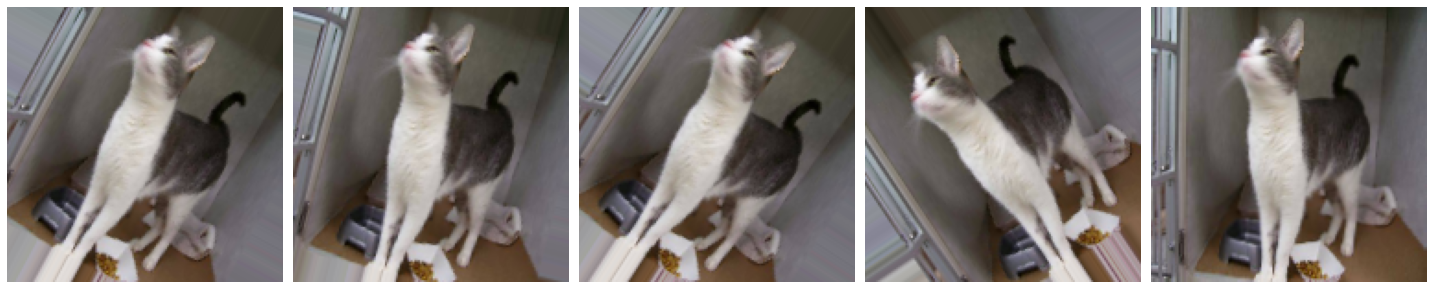

In [ ]:
# 上で学習用画像の可視化のために定義、使用されたおなじカスタムプロット関数を再利用する
plotImages(augmented_images)

## 画像のランダムな回転
回転のデータ拡張を利用して学習用サンプルをランダムに左右45度の範囲で回転させてみましょう。

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


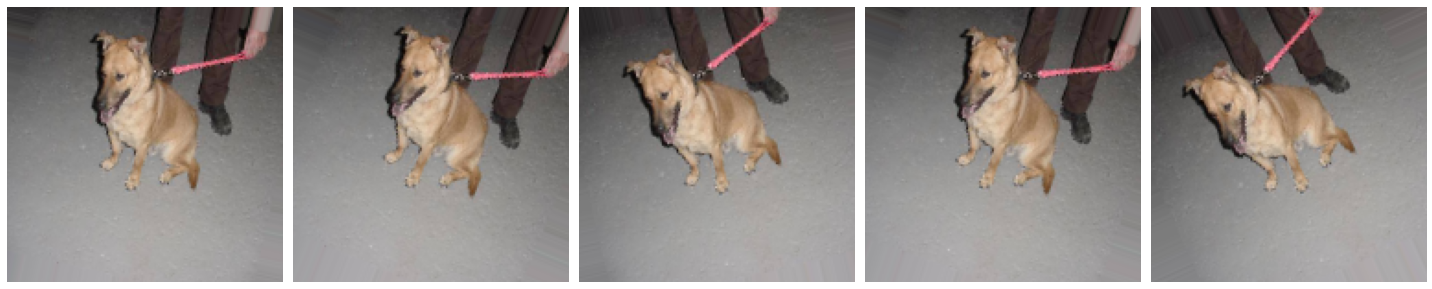

In [ ]:
plotImages(augmented_images)

## ズームによるデータ拡張の適用
データセットにズームによるデータ拡張を適用して、画像をランダムに最大50％拡大します。

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


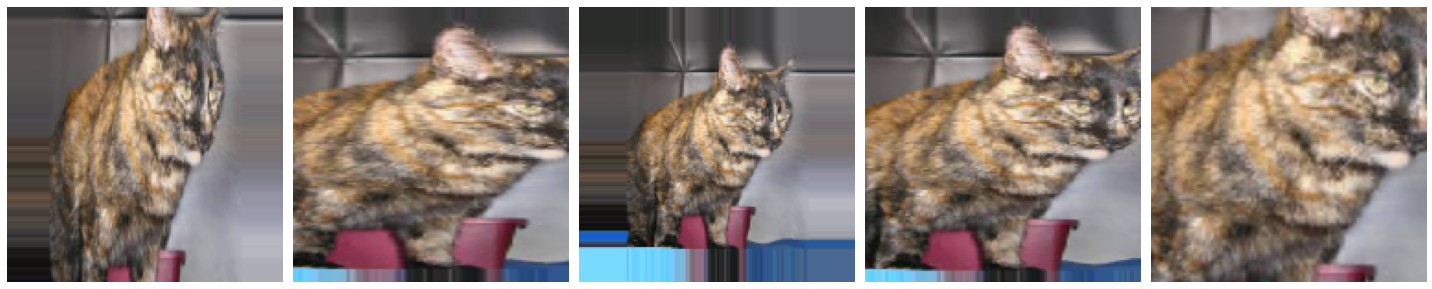

In [ ]:
plotImages(augmented_images)

## すべてのデータ拡張を同時に利用する
ここまでで紹介したすべてのデータ拡張機能を適用します。ここでは、学習用画像に対して、リスケール、45度の回転、幅シフト、高さシフト、水平反転、ズームを適用しました。

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255, #  画素値のリスケーリング係数
                    rotation_range=45, # 画像をランダムに回転する回転範囲
                    width_shift_range=.15, # ランダムに水平シフトする範囲
                    height_shift_range=.15, # ランダムに垂直シフトする範囲
                    horizontal_flip=True, # 水平反転
                    zoom_range=0.5 # ランダムにズームする範囲最大50%
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


これらのデータ拡張がデータセットにランダムに適用されたときに、一つの画像に対して5回の個別の適用を行った際にそれぞれどのように見えるかを可視化します。

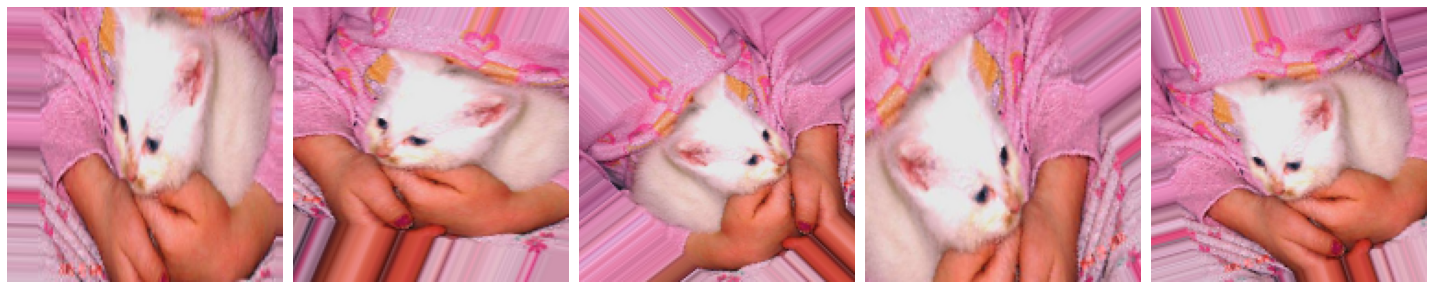

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## 検証データジェネレータの構築
一般に、データ拡張は学習サンプルのみに適用します。今回は、 ImageDataGenerator を使用して検証画像に対してリスケールのみを実施し、バッチに変換します。

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## ドロップアウト（dropout）
過学習を避けるもう一つの方法は、ネットワークに ドロップアウト を導入することです。これは、ネットワークにおいて重みを小さくする正則化の方式で、これによって重みの値の分布がより規則的になり、少ない学習データに対する過学習を減らすことができます。ドロップアウトはこのチュートリアルで利用される正則化手法の一つです。

ドロップアウトをレイヤーに適用すると、学習プロセス中に適用されたレイヤーのうちランダムに出力ユニットをドロップアウト（ゼロに設定）します。ドロップアウトは、入力値として0.1、0.2、0.4といった形式の小数をとります。これは、適用されたレイヤーからランダムに出力単位の10％、20％、または40％をドロップアウトすることを意味します。

特定のレイヤーに0.1ドロップアウトを適用すると、各学習エポックにおいて出力ユニットの10％がランダムに0にされます。

この新しいドロップアウト機能を使用したネットワークアーキテクチャを作成し、異なる畳み込みレイヤーや全接続レイヤーに適用してみましょう。

dropuot = ある更新で層の中のノードのうちのいくつかを無効にして（そもそも存在しないかのように扱って）学習を行い、次の更新では別のノードを無効にして学習を行うことを繰り返します

## ドロップアウトを追加した新しいネットワークの構築
ここでは、ドロップアウトを最初と最後の max pool 層に適用します。ドロップアウトを適用すると、各学習エポック中にニューロンの20％がランダムにゼロに設定されます。これにより、学習データセットに対する過学習を避けることができます。

In [ ]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2), # 20%
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2), # 20%
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

## モデルのコンパイル
ネットワークにドロップアウトを導入した後、モデルをコンパイルし、レイヤーの概要を表示します。

In [ ]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

## モデルの学習
学習サンプルにデータ拡張を導入し、ネットワークにドロップアウトを追加した後、この新しいネットワークを学習します:

In [ ]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
15/15 [==============================] - 18s 1s/step - loss: 1.3721 - accuracy: 0.4813 - val_loss: 0.6928 - val_accuracy: 0.4978
Epoch 2/15
15/15 [==============================] - 17s 1s/step - loss: 0.6939 - accuracy: 0.5118 - val_loss: 0.6914 - val_accuracy: 0.5625
Epoch 3/15
15/15 [==============================] - 18s 1s/step - loss: 0.6915 - accuracy: 0.5192 - val_loss: 0.6896 - val_accuracy: 0.5647
Epoch 4/15
15/15 [==============================] - 18s 1s/step - loss: 0.6917 - accuracy: 0.5144 - val_loss: 0.6899 - val_accuracy: 0.5547
Epoch 5/15
15/15 [==============================] - 17s 1s/step - loss: 0.6859 - accuracy: 0.5433 - val_loss: 0.6851 - val_accuracy: 0.5525
Epoch 6/15
15/15 [==============================] - 17s 1s/step - loss: 0.6769 - accuracy: 0.5694 - val_loss: 0.6855 - val_accuracy: 0.5692
Epoch 7/15
15/15 [==============================] - 17s 1s/step - loss: 0.6763 - acc

## モデルの可視化
学習後に新しいモデルを可視化すると、過学習が前回よりも大幅に少ないことがわかります。より多くのエポックでモデルを学習すると、精度はさらに向上するはずです。

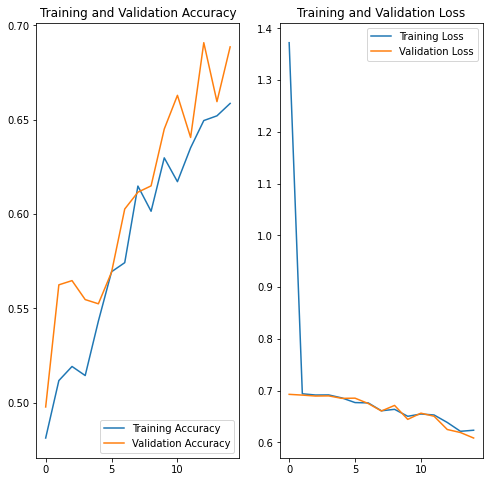

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

データ拡張（data Augmentation）、ドロップアウト（dropout）を使用し無事過学習から逃れた

片方だけだとどうなるんだ?

## データ拡張のみ


In [ ]:
image_gen_train2 = ImageDataGenerator(
                    rescale=1./255, #  画素値のリスケーリング係数
                    rotation_range=45, # 画像をランダムに回転する回転範囲
                    width_shift_range=.15, # ランダムに水平シフトする範囲
                    height_shift_range=.15, # ランダムに垂直シフトする範囲
                    horizontal_flip=True, # 水平反転
                    zoom_range=0.5 # ランダムにズームする範囲最大50%
                    )

In [ ]:
train_data_gen2 = image_gen_train2.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
image_gen_val2 = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen2 = image_gen_val2.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [ ]:
from keras import backend as K

K.clear_session()

model_new2 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_new2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [ ]:
history = model_new2.fit(
    train_data_gen2,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen2,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 18s 1s/step - loss: 0.5608 - accuracy: 0.7142 - val_loss: 0.5777 - val_accuracy: 0.6987
Epoch 2/15
15/15 [==============================] - 17s 1s/step - loss: 0.5852 - accuracy: 0.6891 - val_loss: 0.5842 - val_accuracy: 0.6797
Epoch 3/15
15/15 [==============================] - 17s 1s/step - loss: 0.5575 - accuracy: 0.7153 - val_loss: 0.5599 - val_accuracy: 0.6830
Epoch 4/15
15/15 [==============================] - 18s 1s/step - loss: 0.5687 - accuracy: 0.6976 - val_loss: 0.5947 - val_accuracy: 0.6596
Epoch 5/15
15/15 [==============================] - 17s 1s/step - loss: 0.5630 - accuracy: 0.7089 - val_loss: 0.6069 - val_accuracy: 0.6618
Epoch 6/15
15/15 [==============================] - 17s 1s/step - loss: 0.5625 - accuracy: 0.7062 - val_loss: 0.5848 - val_accuracy: 0.6730
Epoch 7/15
15/15 [==============================] - 17s 1s/step - loss: 0.5687 - accuracy: 0.7089 - val_loss: 0.5682 - val_accuracy: 0.7042
Epoch 8/15
15/15 [==

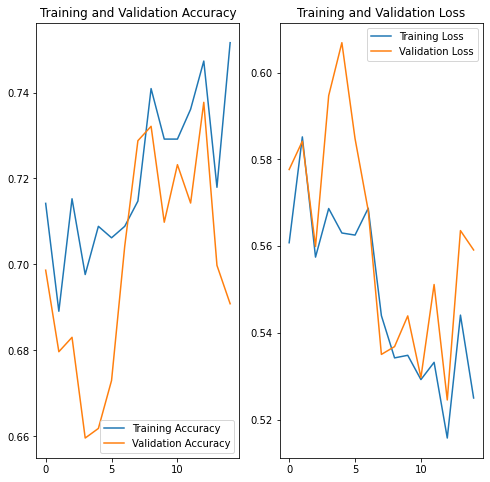

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

なんやこのグラフ！？

データ拡張のみだと最初よりはましかな？

dropoutのみ

In [ ]:
K.clear_session()

model_new3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2), # 20%
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2), # 20%
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_new3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

In [ ]:
history = model_new3.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 18s 1s/step - loss: 1.0520 - accuracy: 0.4845 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/15
15/15 [==============================] - 18s 1s/step - loss: 0.6929 - accuracy: 0.5052 - val_loss: 0.6926 - val_accuracy: 0.5167
Epoch 3/15
15/15 [==============================] - 18s 1s/step - loss: 0.6927 - accuracy: 0.5176 - val_loss: 0.6922 - val_accuracy: 0.5357
Epoch 4/15
15/15 [==============================] - 18s 1s/step - loss: 0.6925 - accuracy: 0.5115 - val_loss: 0.6921 - val_accuracy: 0.5089
Epoch 5/15
15/15 [==============================] - 18s 1s/step - loss: 0.6870 - accuracy: 0.5540 - val_loss: 0.6831 - val_accuracy: 0.5603
Epoch 6/15
15/15 [==============================] - 18s 1s/step - loss: 0.6835 - accuracy: 0.5545 - val_loss: 0.6817 - val_accuracy: 0.5569
Epoch 7/15
15/15 [==============================] - 18s 1s/step - loss: 0.6781 - accuracy: 0.5710 - val_loss: 0.6719 - val_accuracy: 0.6004
Epoch 8/15
15/15 [==

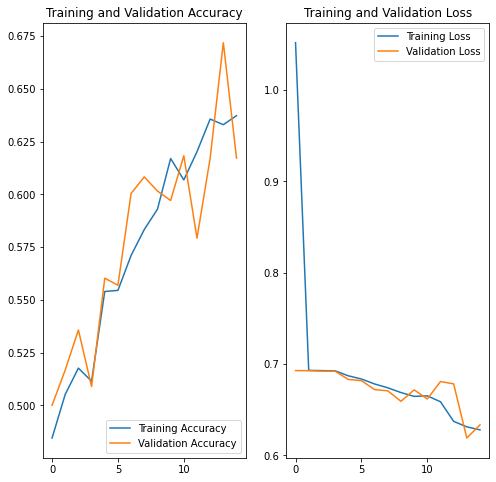

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

データによるとしか言いようがないが

今回はデータ拡張よりdropoutの方が効果がある